# Example-16: Henon fractal (parametric fixed points)

In [1]:
# In this example periodic fixed points for several low orders are computed along symmetry lines

In [2]:
# Import

from tqdm import tqdm

import numpy

import jax
from jax import jit
from jax import vmap

# Test symplectic mapping and corresponding inverse

from tohubohu.util import forward2D
from tohubohu.util import inverse2D

# GALI factory

from tohubohu import gali

# Fixed point

from tohubohu import iterate
from tohubohu import prime
from tohubohu import unique
from tohubohu import chain
from tohubohu import monodromy
from tohubohu import combine
from tohubohu import classify
from tohubohu import manifold

# Plotting

from matplotlib import pyplot as plt
from matplotlib import colormaps

cmap = colormaps.get_cmap('viridis')
cmap.set_bad(color='lightgray')

In [3]:
# Set data type

jax.config.update("jax_enable_x64", True)

In [4]:
# Set device

device, *_ = jax.devices('cpu')
jax.config.update('jax_default_device', device)

In [5]:
# Set symmetry lines

def diagonal(q, k):
    w, s = k
    return q

def force(q, k):
    w, s = k
    return 0.5*(w*q + q**2 + s*q**3)

In [6]:
# Set indicator

indicator = gali(2**10, forward2D)

x = jax.numpy.array([0.0, 0.0])
k = jax.numpy.array([0.5, 0.0])
v = jax.numpy.array([[1.0, 0.0], [0.0, 1.0]])

out = indicator(x, v, k)

In [7]:
# Set grid

n = 501

ws = jax.numpy.linspace(-3.0, 2.0, n)
qs = jax.numpy.linspace(-1.25, 1.75, n)
xs = jax.numpy.stack(jax.numpy.meshgrid(ws, qs, indexing='ij')).swapaxes(-1, 0).reshape(n*n, -1)

In [8]:
# Set 'parametric' indicators for each symmetry line

v = jax.numpy.array([[1.0, 0.0], [0.0, 1.0]])
s = jax.numpy.float64(0.0)

def fn_diagonal(x, level=5.0E-16):
    w, q = x
    k = jax.numpy.stack([w, s])
    return jax.numpy.log10(level + indicator(jax.numpy.stack([q, diagonal(q, k)]), v, k))

def fn_force(x, level=5.0E-16):
    w, q = x
    k = jax.numpy.stack([w, s])
    return jax.numpy.log10(level + indicator(jax.numpy.stack([q, force(q, k)]), v, k))

In [9]:
%%time

# Diagonal line fractal

out_diagonal = jit(vmap(fn_diagonal))(xs).reshape(n, n).block_until_ready()

CPU times: user 26 s, sys: 563 ms, total: 26.6 s
Wall time: 8.96 s


In [10]:
%%time

# Force line fractal

out_force = jit(vmap(fn_force))(xs).reshape(n, n).block_until_ready()

CPU times: user 26.9 s, sys: 567 ms, total: 27.5 s
Wall time: 9.2 s


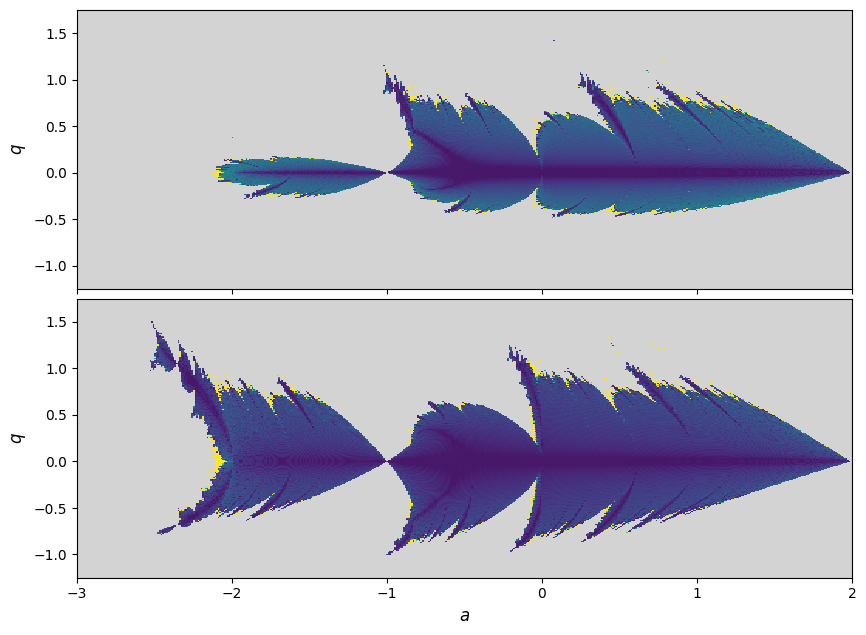

In [11]:
# Plot fractals

cmap = colormaps.get_cmap('viridis_r')
cmap.set_bad(color='lightgray')

fig, (ax, ay) = plt.subplots( nrows=2, figsize=(10, 10), sharex=True, gridspec_kw={'hspace': -0.4}, num=1, clear=True)
ax.imshow(out_diagonal, aspect=3/5, vmin=-15.0, vmax=1.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-3, 2, -1.25, 1.75))
ay.imshow(out_force, aspect=3/5, vmin=-15.0, vmax=1.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-3, 2, -1.25, 1.75))

ax.set_ylabel(r'$q$', fontsize=12)
ay.set_ylabel(r'$q$', fontsize=12)  
ay.set_xlabel(r'$a$', fontsize=12)

plt.show()

In [12]:
# Define function for fixed point computation

def task(order, mapping, initials, *knobs, limit=16, tol=1.0E-12):
    solver = jit(vmap(iterate(limit, mapping, order=order), (0, None)))
    points = solver(initials, *knobs)
    points = points[~jax.numpy.any(jax.numpy.isnan(points), -1)]
    mask = jit(vmap(prime(mapping, order=order, rtol=tol, atol=tol), (0, None)))(points, *knobs)
    points = points[mask]
    mask = unique(order, mapping, points, *knobs, tol=tol)
    points = points[mask]
    if not points.size:
        return None, None
    chains = jit(vmap(chain(order, mapping), (0, None)))(points, *knobs)
    ms = jit(vmap(monodromy(order, mapping), (0, None)))(points, *knobs)
    es, _ = vmap(jax.numpy.linalg.eig)(ms)
    mask = classify(es)
    return chains, mask

In [13]:
# Locate fixed points

order = 1
size = 256
limit = 64
tol = 1.0E-15

qs = jax.numpy.linspace(-1.25, 1.75, size)

ep_a = []
hp_a = []

ep_b = []
hp_b = []

for w in tqdm(ws):
    knobs = jax.numpy.stack([w, s])
    pa = diagonal(qs, knobs)
    pb = force(qs, knobs)
    xs = jax.numpy.vstack([jax.numpy.stack([qs, pa]).T, jax.numpy.stack([qs, pb]).T])
    cs, ks = task(order, forward2D, xs, knobs, limit=limit, tol=tol)
    if cs is None:
        continue
    for c, k in zip(cs, ks):
        qc, pc = c.T
        qa, _ = c[jax.numpy.abs(diagonal(qc, knobs) - pc) < tol].T
        qb, _ = c[jax.numpy.abs(force(qc, knobs) - pc) < tol].T
        xa = jax.numpy.stack([jax.numpy.full_like(qa.squeeze(), w), qa.squeeze()]).T
        xb = jax.numpy.stack([jax.numpy.full_like(qb.squeeze(), w), qb.squeeze()]).T
        if xa.size:
            ep_a.append(xa[k])
            hp_a.append(xa[~k])
        if xb.size:
            ep_b.append(xb[k])
            hp_b.append(xb[~k])

100%|███████████████████████████████████████████████████████████████████████████████████████████| 501/501 [04:16<00:00,  1.96it/s]


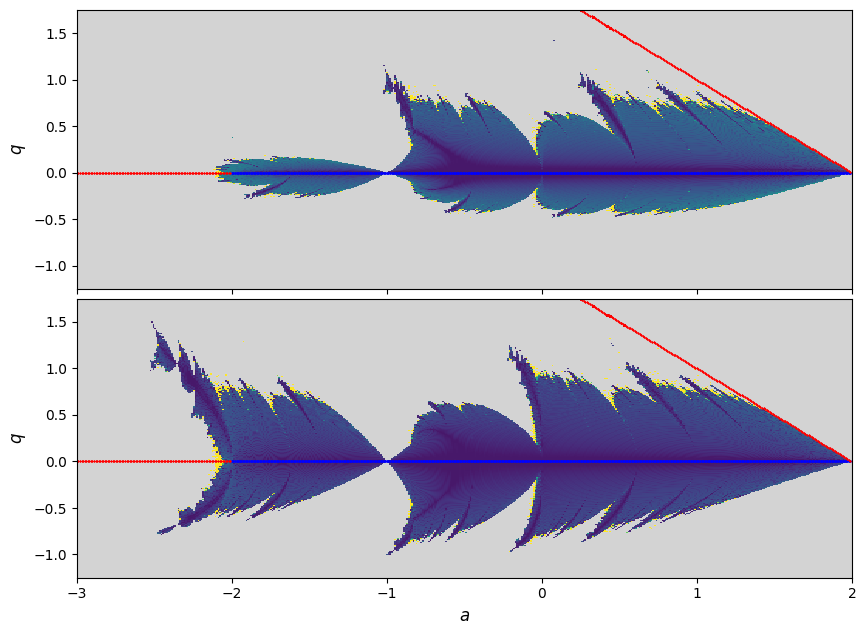

In [14]:
# Plot

cmap = colormaps.get_cmap('viridis_r')
cmap.set_bad(color='lightgray')

va = [value.squeeze().reshape(-1, 2) for value in ep_a] + [jax.numpy.array([[10.0, 0.0]])]
va = jax.numpy.concatenate(va)

ua = [value.squeeze().reshape(-1, 2) for value in hp_a] + [jax.numpy.array([[10.0, 0.0]])]
ua = jax.numpy.concatenate(ua)

vb = [value.squeeze().reshape(-1, 2) for value in ep_b] + [jax.numpy.array([[10.0, 0.0]])]
vb = jax.numpy.concatenate(vb)

ub = [value.squeeze().reshape(-1, 2) for value in hp_b] + [jax.numpy.array([[10.0, 0.0]])]
ub = jax.numpy.concatenate(ub)

fig, (ax, ay) = plt.subplots(nrows=2, figsize=(10, 10), sharex=True, gridspec_kw={'hspace': -0.4}, num=1, clear=True)

ax.imshow(out_diagonal, aspect=3/5, vmin=-15.0, vmax=1.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-3, 2, -1.25, 1.75))
ax.errorbar(*va.T, color='blue', fmt=' ', marker='o', ms=1)
ax.errorbar(*ua.T, color='red', fmt=' ', marker='x', ms=1)
ax.set_ylim(-1.25, 1.75)
ax.set_xlim(-3, 2)

ay.imshow(out_force, aspect=3/5, vmin=-15.0, vmax=1.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-3, 2, -1.25, 1.75))
ay.errorbar(*vb.T, color='blue', fmt=' ', marker='o', ms=1)
ay.errorbar(*ub.T, color='red', fmt=' ', marker='x', ms=1)
ay.set_ylim(-1.25, 1.75)
ay.set_xlim(-3, 2)

ax.set_ylabel(r'$q$', fontsize=12)
ay.set_ylabel(r'$q$', fontsize=12)  
ay.set_xlabel(r'$a$', fontsize=12)

plt.show()

In [15]:
# Locate fixed points

order = 2
size = 256
limit = 64
tol = 1.0E-15

qs = jax.numpy.linspace(-1.25, 1.75, size)

ep_a = []
hp_a = []

ep_b = []
hp_b = []

for w in tqdm(ws):
    knobs = jax.numpy.stack([w, s])
    pa = diagonal(qs, knobs)
    pb = force(qs, knobs)
    xs = jax.numpy.vstack([jax.numpy.stack([qs, pa]).T, jax.numpy.stack([qs, pb]).T])
    cs, ks = task(order, forward2D, xs, knobs, limit=limit, tol=tol)
    if cs is None:
        continue
    for c, k in zip(cs, ks):
        qc, pc = c.T
        qa, _ = c[jax.numpy.abs(diagonal(qc, knobs) - pc) < tol].T
        qb, _ = c[jax.numpy.abs(force(qc, knobs) - pc) < tol].T
        xa = jax.numpy.stack([jax.numpy.full_like(qa.squeeze(), w), qa.squeeze()]).T
        xb = jax.numpy.stack([jax.numpy.full_like(qb.squeeze(), w), qb.squeeze()]).T
        if xa.size:
            ep_a.append(xa[k])
            hp_a.append(xa[~k])
        if xb.size:
            ep_b.append(xb[k])
            hp_b.append(xb[~k])

100%|███████████████████████████████████████████████████████████████████████████████████████████| 501/501 [06:10<00:00,  1.35it/s]


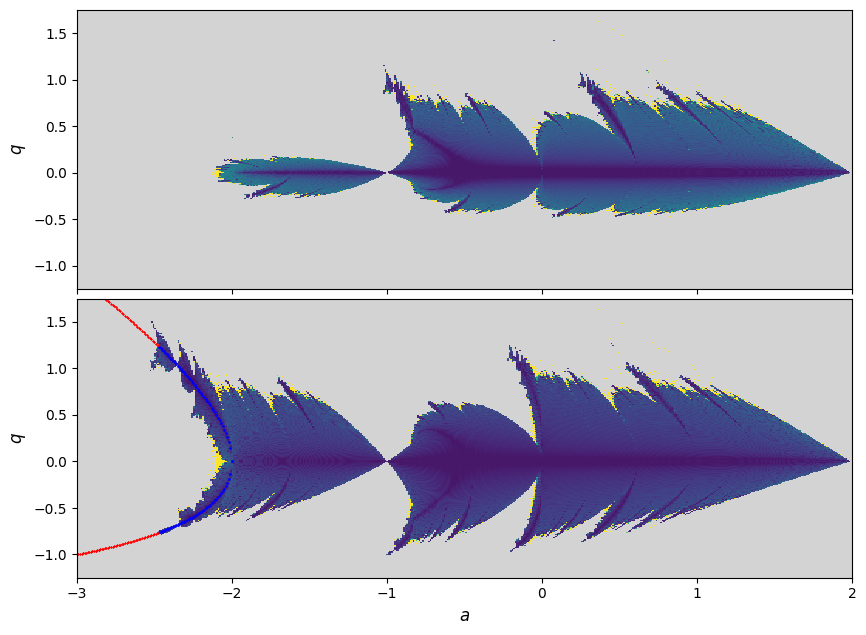

In [16]:
# Plot

cmap = colormaps.get_cmap('viridis_r')
cmap.set_bad(color='lightgray')

va = [value.squeeze().reshape(-1, 2) for value in ep_a] + [jax.numpy.array([[10.0, 0.0]])]
va = jax.numpy.concatenate(va)

ua = [value.squeeze().reshape(-1, 2) for value in hp_a] + [jax.numpy.array([[10.0, 0.0]])]
ua = jax.numpy.concatenate(ua)

vb = [value.squeeze().reshape(-1, 2) for value in ep_b] + [jax.numpy.array([[10.0, 0.0]])]
vb = jax.numpy.concatenate(vb)

ub = [value.squeeze().reshape(-1, 2) for value in hp_b] + [jax.numpy.array([[10.0, 0.0]])]
ub = jax.numpy.concatenate(ub)

fig, (ax, ay) = plt.subplots(nrows=2, figsize=(10, 10), sharex=True, gridspec_kw={'hspace': -0.4}, num=1, clear=True)

ax.imshow(out_diagonal, aspect=3/5, vmin=-15.0, vmax=1.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-3, 2, -1.25, 1.75))
ax.errorbar(*va.T, color='blue', fmt=' ', marker='o', ms=1)
ax.errorbar(*ua.T, color='red', fmt=' ', marker='x', ms=1)
ax.set_ylim(-1.25, 1.75)
ax.set_xlim(-3, 2)

ay.imshow(out_force, aspect=3/5, vmin=-15.0, vmax=1.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-3, 2, -1.25, 1.75))
ay.errorbar(*vb.T, color='blue', fmt=' ', marker='o', ms=1)
ay.errorbar(*ub.T, color='red', fmt=' ', marker='x', ms=1)
ay.set_ylim(-1.25, 1.75)
ay.set_xlim(-3, 2)

ax.set_ylabel(r'$q$', fontsize=12)
ay.set_ylabel(r'$q$', fontsize=12)  
ay.set_xlabel(r'$a$', fontsize=12)

plt.show()

In [17]:
# Locate fixed points

order = 3
size = 256
limit = 64
tol = 1.0E-15

qs = jax.numpy.linspace(-1.25, 1.75, size)

ep_a = []
hp_a = []

ep_b = []
hp_b = []

for w in tqdm(ws):
    knobs = jax.numpy.stack([w, s])
    pa = diagonal(qs, knobs)
    pb = force(qs, knobs)
    xs = jax.numpy.vstack([jax.numpy.stack([qs, pa]).T, jax.numpy.stack([qs, pb]).T])
    cs, ks = task(order, forward2D, xs, knobs, limit=limit, tol=tol)
    if cs is None:
        continue
    for c, k in zip(cs, ks):
        qc, pc = c.T
        qa, _ = c[jax.numpy.abs(diagonal(qc, knobs) - pc) < tol].T
        qb, _ = c[jax.numpy.abs(force(qc, knobs) - pc) < tol].T
        xa = jax.numpy.stack([jax.numpy.full_like(qa.squeeze(), w), qa.squeeze()]).T
        xb = jax.numpy.stack([jax.numpy.full_like(qb.squeeze(), w), qb.squeeze()]).T
        if xa.size:
            ep_a.append(xa[k])
            hp_a.append(xa[~k])
        if xb.size:
            ep_b.append(xb[k])
            hp_b.append(xb[~k])

100%|███████████████████████████████████████████████████████████████████████████████████████████| 501/501 [08:35<00:00,  1.03s/it]


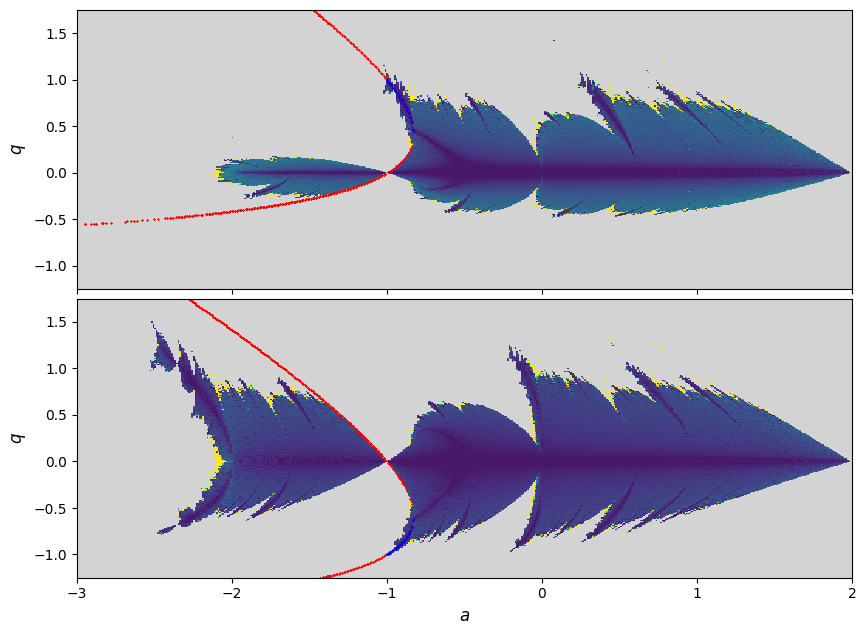

In [18]:
# Plot

cmap = colormaps.get_cmap('viridis_r')
cmap.set_bad(color='lightgray')

va = [value.squeeze().reshape(-1, 2) for value in ep_a] + [jax.numpy.array([[10.0, 0.0]])]
va = jax.numpy.concatenate(va)

ua = [value.squeeze().reshape(-1, 2) for value in hp_a] + [jax.numpy.array([[10.0, 0.0]])]
ua = jax.numpy.concatenate(ua)

vb = [value.squeeze().reshape(-1, 2) for value in ep_b] + [jax.numpy.array([[10.0, 0.0]])]
vb = jax.numpy.concatenate(vb)

ub = [value.squeeze().reshape(-1, 2) for value in hp_b] + [jax.numpy.array([[10.0, 0.0]])]
ub = jax.numpy.concatenate(ub)

fig, (ax, ay) = plt.subplots(nrows=2, figsize=(10, 10), sharex=True, gridspec_kw={'hspace': -0.4}, num=1, clear=True)

ax.imshow(out_diagonal, aspect=3/5, vmin=-15.0, vmax=1.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-3, 2, -1.25, 1.75))
ax.errorbar(*va.T, color='blue', fmt=' ', marker='o', ms=1)
ax.errorbar(*ua.T, color='red', fmt=' ', marker='x', ms=1)
ax.set_ylim(-1.25, 1.75)
ax.set_xlim(-3, 2)

ay.imshow(out_force, aspect=3/5, vmin=-15.0, vmax=1.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-3, 2, -1.25, 1.75))
ay.errorbar(*vb.T, color='blue', fmt=' ', marker='o', ms=1)
ay.errorbar(*ub.T, color='red', fmt=' ', marker='x', ms=1)
ay.set_ylim(-1.25, 1.75)
ay.set_xlim(-3, 2)

ax.set_ylabel(r'$q$', fontsize=12)
ay.set_ylabel(r'$q$', fontsize=12)  
ay.set_xlabel(r'$a$', fontsize=12)

plt.show()

In [19]:
# Locate fixed points

order = 5
size = 256
limit = 64
tol = 1.0E-15

qs = jax.numpy.linspace(-1.25, 1.75, size)

ep_a = []
hp_a = []

ep_b = []
hp_b = []

for w in tqdm(ws):
    knobs = jax.numpy.stack([w, s])
    pa = diagonal(qs, knobs)
    pb = force(qs, knobs)
    xs = jax.numpy.vstack([jax.numpy.stack([qs, pa]).T, jax.numpy.stack([qs, pb]).T])
    cs, ks = task(order, forward2D, xs, knobs, limit=limit, tol=tol)
    if cs is None:
        continue
    for c, k in zip(cs, ks):
        qc, pc = c.T
        qa, _ = c[jax.numpy.abs(diagonal(qc, knobs) - pc) < tol].T
        qb, _ = c[jax.numpy.abs(force(qc, knobs) - pc) < tol].T
        xa = jax.numpy.stack([jax.numpy.full_like(qa.squeeze(), w), qa.squeeze()]).T
        xb = jax.numpy.stack([jax.numpy.full_like(qb.squeeze(), w), qb.squeeze()]).T
        if xa.size:
            ep_a.append(xa[k])
            hp_a.append(xa[~k])
        if xb.size:
            ep_b.append(xb[k])
            hp_b.append(xb[~k])

100%|███████████████████████████████████████████████████████████████████████████████████████████| 501/501 [08:17<00:00,  1.01it/s]


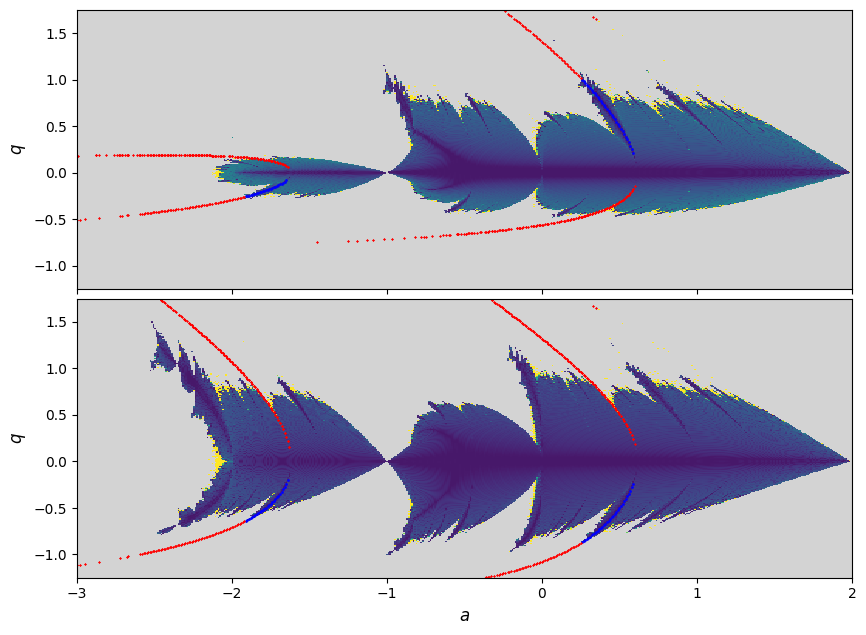

In [20]:
# Plot

cmap = colormaps.get_cmap('viridis_r')
cmap.set_bad(color='lightgray')

va = [value.squeeze().reshape(-1, 2) for value in ep_a] + [jax.numpy.array([[10.0, 0.0]])]
va = jax.numpy.concatenate(va)

ua = [value.squeeze().reshape(-1, 2) for value in hp_a] + [jax.numpy.array([[10.0, 0.0]])]
ua = jax.numpy.concatenate(ua)

vb = [value.squeeze().reshape(-1, 2) for value in ep_b] + [jax.numpy.array([[10.0, 0.0]])]
vb = jax.numpy.concatenate(vb)

ub = [value.squeeze().reshape(-1, 2) for value in hp_b] + [jax.numpy.array([[10.0, 0.0]])]
ub = jax.numpy.concatenate(ub)

fig, (ax, ay) = plt.subplots(nrows=2, figsize=(10, 10), sharex=True, gridspec_kw={'hspace': -0.4}, num=1, clear=True)

ax.imshow(out_diagonal, aspect=3/5, vmin=-15.0, vmax=1.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-3, 2, -1.25, 1.75))
ax.errorbar(*va.T, color='blue', fmt=' ', marker='o', ms=1)
ax.errorbar(*ua.T, color='red', fmt=' ', marker='x', ms=1)
ax.set_ylim(-1.25, 1.75)
ax.set_xlim(-3, 2)

ay.imshow(out_force, aspect=3/5, vmin=-15.0, vmax=1.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-3, 2, -1.25, 1.75))
ay.errorbar(*vb.T, color='blue', fmt=' ', marker='o', ms=1)
ay.errorbar(*ub.T, color='red', fmt=' ', marker='x', ms=1)
ay.set_ylim(-1.25, 1.75)
ay.set_xlim(-3, 2)

ax.set_ylabel(r'$q$', fontsize=12)
ay.set_ylabel(r'$q$', fontsize=12)  
ay.set_xlabel(r'$a$', fontsize=12)

plt.show()